## Package and helper imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from textblob import TextBlob

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack
import pyarrow
import pickle

C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downloads and display options
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
punctuation = string.punctuation
stop_words = set(stopwords.words('english'))
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\schellr2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Define functions

In [3]:
def clean_text_df(data):
    for i in [char for char in ':;"?,/|\\}{1234567890.~!@#$%^&*_+=<>']:
        data.unvec=data.unvec.apply(lambda x: str(x).replace(i,""))

    data.unvec=data.unvec.apply(lambda x: str(x).replace('-'," "))

    stopword_dict= set(stopwords.words('english'))

    def sw_remover(arr):
        res=[]
        for i in arr:
            if i not in stopword_dict:
                res.append(i)
        return res

    # def digit_remover(arr):
    #     res=[]
    #     for i in arr:
    #         if i.isdigit()==False:
    #             res.append(i)
    #     return res

    def lemmatizer(arr):
        lem=nltk.stem.WordNetLemmatizer()
        res=[lem.lemmatize(i) for i in arr]
        return res

    def joiner(arr):
        if len(arr)==0:
            return ''
        elif len(arr)==1:
            return arr[0]
        else:
            return ' '.join(arr)
    
    data.unvec=data.unvec.apply(lambda x: re.sub(r'\[rnt]',"",x))
    data.unvec=data.unvec.apply(lambda x: x.lower())
    data.unvec=data.unvec.apply(lambda x: x.split())
    data.unvec=data.unvec.apply(sw_remover)
    data.unvec=data.unvec.apply(lemmatizer)
    data.unvec=data.unvec.apply(joiner)

    data['len']=data['unvec'].apply(len)
    
    return data

In [ ]:
# def cleanText(text):
#     text = BeautifulSoup(text, "lxml").text
#     text = re.sub(r'\[rnt]', '', text) 
#     text = re.sub(r'http\S+', r'<URL>', text)
#     text = text.lower()
#     text = text.replace('x', '')
#     return text

In [4]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [5]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents]) #(doc.words, steps=20))
    return targets, regressors

## Import data

In [6]:
data = pd.read_parquet('./input/consumer_complaints.parquet')
data.head(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",None,None,None,U.S. Bancorp,CA,95993,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",None,None,None,Wells Fargo & Company,CA,91104,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,None,Incorrect information on credit report,Account status,None,None,Wells Fargo & Company,NY,11764,None,None,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,None,None,"Navient Solutions, Inc.",MD,21402,None,None,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,None,None,Resurgent Capital Services L.P.,GA,30106,None,None,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
5,08/30/2013,Credit card,None,Application processing delay,None,None,None,Capital One,NY,12206,None,None,Phone,09/03/2013,Closed with explanation,Yes,Yes,510098
6,08/30/2013,Credit card,None,Credit line increase/decrease,None,None,None,Wells Fargo & Company,AZ,85730,None,None,Postal mail,09/05/2013,Closed with explanation,Yes,No,511062
7,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,IL,60660,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511116
8,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,GA,30016,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511091
9,09/17/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",None,None,None,"SunTrust Banks, Inc.",CA,94551,None,None,Web,09/18/2013,Closed with explanation,Yes,Yes,530602


In [7]:
# save data to df so won't have to reload data if need to start over with df.
df = data.copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [9]:
# Only keep records with a complaint narrative
df = df[~df['consumer_complaint_narrative'].isnull()]

In [10]:
# Only keep complaint narrative & product columns to see how well diff methods predict product from just text
df = df[['consumer_complaint_narrative', 'product']]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66806 entries, 190126 to 553096
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   consumer_complaint_narrative  66806 non-null  object
 1   product                       66806 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [12]:
df.shape

(66806, 2)

In [13]:
list(df.columns)

['consumer_complaint_narrative', 'product']

In [14]:
product = df['product'].value_counts()
print(product)

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


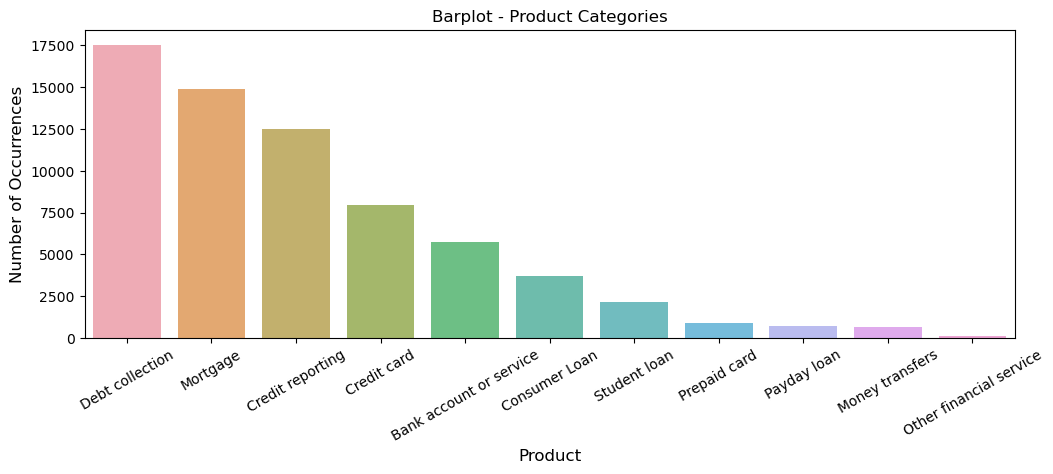

In [15]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8)
plt.title('Barplot - Product Categories')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [16]:
for i in df['consumer_complaint_narrative'].head(5):
    print(i)
    print("#####################")

XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! 
They continue to insist I owe them and collection agencies are after me. 
How can I stop this harassment for a bill I already paid four years ago? 

#####################
Due to inconsistencies in the amount owed that I was told by M & T Bank and the amount that was reported to the credit reporting agencies, I was advised to write a good will letter in order to address the issue and request the negative entry be removed from my credit report all together. I had a vehicle that was stolen and it was declared a total loss by insurance company. The insurance company and the GAP insurancw companypaid the outstanding balance of the loan, but I was told by M & T Bank that there was still a balance due on the loan. In good faith, without having received any proof as to why there was still a balance, I made a partial payment towards the remaining

In [17]:
df = df.rename({'consumer_complaint_narrative':'unvec', 'product':'label'},axis=1)

In [18]:
df['unvec'] = df['unvec'].astype(str)

In [19]:
df.head()

,unvec,label
190126,XXXX has claimed I owe them {$27.00} for XXXX ...,Debt collection
190135,Due to inconsistencies in the amount owed that...,Consumer Loan
190155,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
190207,I have an open and current mortgage with Chase...,Mortgage
190208,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage


## Sanitize text

In [20]:
df = clean_text_df(df)

In [21]:
for i in df['unvec'].head(5):
    print(i)
    print("#####################")

xxxx claimed owe xxxx year despite proof payment sent canceled check ownpaid invoice continue insist owe collection agency stop harassment bill already paid four year ago
#####################
due inconsistency amount owed told bank amount reported credit reporting agency advised write good letter order address issue request negative entry removed credit report together vehicle stolen declared total loss insurance company insurance company gap insurancw companypaid outstanding balance loan told bank still balance due loan good faith without received proof still balance made partial payment towards remaining debt sent goodwill letter still offering pay remainder debt exchange removal negative entry credit report one point xxxx per credit monitoring agency showed delinquent balance checked credit report xxxx xxxx delinquent balance monies gap insurance insurance company paid bank say still owe already paid contacted bank via return receipt mail given courtesy response yet
###############

In [22]:
for i in df['label'].head(5):
    print(i)
    print("#####################")

Debt collection
#####################
Consumer Loan
#####################
Mortgage
#####################
Mortgage
#####################
Mortgage
#####################


## Stratified shuffle split data into training and test datasets

In [23]:
# Use stratified shuffle split to keep same class proportions in train and test data.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=2022)

In [24]:
for train_index, test_index  in sss.split(df, df['label']):
    train_df = df.iloc[train_index]
    test_df  = df.iloc[test_index]

In [25]:
train_df.head()

,unvec,label,len
284037,nationstar mortgage let home owner 's insuranc...,Mortgage,167
289227,applied xxxx autoloan xxxx called first paymen...,Consumer Loan,202
287827,call ( lot different number every day ) every ...,Debt collection,151
316585,contacted reporting xxxx xxxx numerous time go...,Credit reporting,407
498787,saturday xxxx xxxx xxxx wife called well fargo...,Mortgage,1403


In [26]:
test_df.head()

,unvec,label,len
318689,vacated apartment purchase home xxxx xxxx ( co...,Debt collection,1078
268804,recently applied va home loan loan depot xxxx ...,Mortgage,891
491443,ocwen start calling first month prior payment ...,Debt collection,253
264312,public record xxxx xxxx xxxx superior docket x...,Credit reporting,552
324725,transunion allowed individual ( criminal ) usi...,Credit reporting,386


In [27]:
len(train_df)

53444

In [28]:
len(test_df)

13362

In [29]:
test_prop = len(test_df) / (len(test_df) + len(train_df))
print(test_prop)

0.20001197497230788


In [30]:
product_train_df = train_df['label'].value_counts()
print(product_train_df)

Debt collection            14041
Mortgage                   11935
Credit reporting           10021
Credit card                 6343
Bank account or service     4569
Consumer Loan               2942
Student loan                1702
Prepaid card                 689
Payday loan                  581
Money transfers              533
Other financial service       88
Name: label, dtype: int64


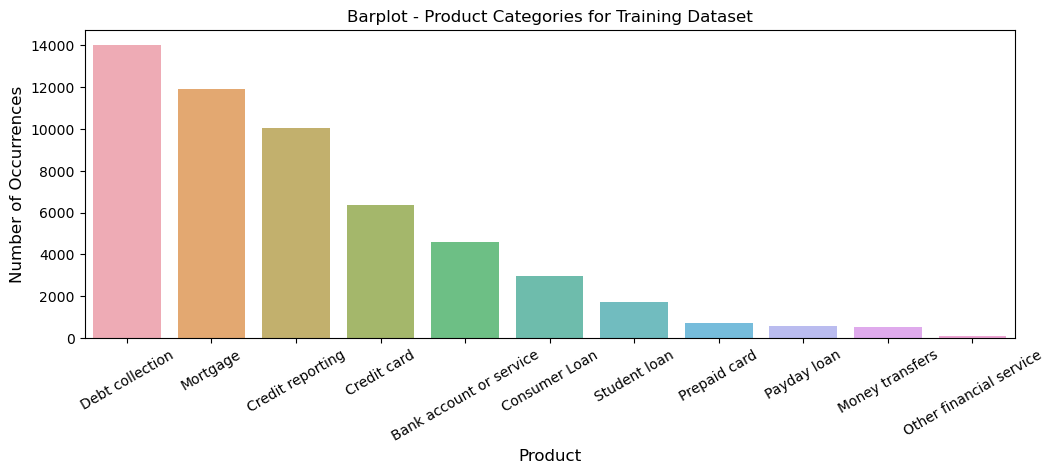

In [31]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_train_df.index, y=product_train_df.values, alpha=0.8)
plt.title('Barplot - Product Categories for Training Dataset')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [32]:
product_test_df = test_df['label'].value_counts()
print(product_test_df)

Debt collection            3511
Mortgage                   2984
Credit reporting           2505
Credit card                1586
Bank account or service    1142
Consumer Loan               736
Student loan                426
Prepaid card                172
Payday loan                 145
Money transfers             133
Other financial service      22
Name: label, dtype: int64


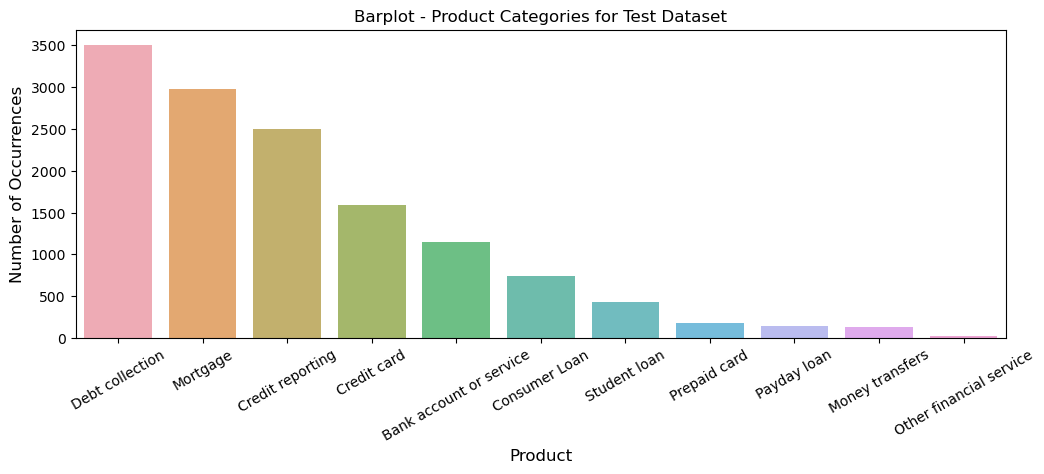

In [33]:
plt.figure(figsize=(12,4))
sns.barplot(x=product_test_df.index, y=product_test_df.values, alpha=0.8)
plt.title('Barplot - Product Categories for Test Dataset')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

- ### Similar class labels proportions in both train and test datasets by using StratifiedShuffleSplit.

In [34]:
# Factorize label to target
train_df['target'] = train_df['label'].astype('category').cat.codes  ## better way to factorize product code to categorical IDs
test_df['target'] = test_df['label'].astype('category').cat.codes

C:\Users\schellr2\AppData\Local\Temp\ipykernel_13076\33861037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target'] = train_df['label'].astype('category').cat.codes  ## better way to factorize product code to categorical IDs
C:\Users\schellr2\AppData\Local\Temp\ipykernel_13076\33861037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'] = test_df['label'].astype('category').cat.codes


In [35]:
train_tagged = train_df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['unvec']), tags=[r['target']]), axis=1)
test_tagged = test_df.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['unvec']), tags=[r['target']]), axis=1)

In [36]:
train_tagged.values[100]

TaggedDocument(words=['process', 'closing', 'home', 'loan', 'instructed', 'pay', 'account', 'contact', 'southern', 'management', 'system', 'talk', 'xxxx', 'xxxx', 'xxxx', 'lady', 'pick', 'phone', 'came', 'agreement', 'pay', 'debt', 'first', 'wanted', 'assure', 'give', 'offer', 'letter', 'letter', 'paid', 'debt', 'payment', 'processed', 'upon', 'requesting', 'document', 'xxxx', 'xxxx', "'s", 'professionalism', 'left', 'began', 'extremely', 'rude', 'said', 'sending', 'anything', "n't", 'like', 'bad', 'back', 'forth', 'moment', 'hung', 'tried', 'resolve', 'issue', 'never', 'call', 'back', 'also', 'asked', 'could', 'verify', 'debt', 'refused', 'could', 'well', 'hurt', 'approval', 'loan', 'trying', 'pay', 'wont', 'work'], tags=[4])

In [37]:
test_tagged.values[100]

TaggedDocument(words=['credit', 'indebtedness', 'satisfied', 'yet', 'credit', 'card', 'company', 'reluctant', 'remove', 'change', 'status', 'credit', 'report'], tags=[3])

In [38]:
import multiprocessing
cores = multiprocessing.cpu_count()
print(cores)

12


In [39]:
# First make distributed Bag-of-Words model
# create 300 dimension vectors
model_dbow = Doc2Vec(
    dm=0,             # 0 or 1 - 0 for distributed BOW that is like word2vec skipgram or 1 for distributed memory
    vector_size=300,  # 
    min_count=2,      # ignores all words with total frq less than this
    #negative=5,       # specifies how many noisy words to draw out
    workers=cores
)

In [40]:
# Also make distributed Memory model
# Also create 300 dimension vectors
model_dm = Doc2Vec(
    dm=1,             # 0 or 1 - 0 for distributed BOW that is like word2vec skipgram or 1 for distributed memory
    vector_size=300,  # 
    min_count=2,      # ignores all words with total frq less than this
    #negative=5,       # specifies how many noisy words to draw out
    workers=cores
)

In [41]:
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 53444/53444 [00:00<00:00, 2552352.78it/s]


In [42]:
%%time
for epoch in range(30):
    model_dbow.train(shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 53444/53444 [00:00<00:00, 5850460.21it/s]


CPU times: total: 3min 56s
Wall time: 1min 26s


In [43]:
model_dm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 53444/53444 [00:00<00:00, 3340093.92it/s]


In [44]:
%%time
for epoch in range(30):
    model_dm.train(shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 53444/53444 [00:00<00:00, 6065930.16it/s]


CPU times: total: 6min 32s
Wall time: 2min 56s


In [45]:
# Output targets and regressors from user-defined vec_for_learning function - dBOW model
y_train_dbow, X_train_dbow = vec_for_learning(model_dbow, train_tagged)
y_test_dbow, X_test_dbow = vec_for_learning(model_dbow, test_tagged)

In [46]:
# Baseline label classifier with logistic regression and minimal params - dBOW model

logreg_dbow = LogisticRegression(
    max_iter=10000,
    random_state=2022,
)

logreg_dbow.fit(X_train_dbow, y_train_dbow)

y_pred_dbow = logreg_dbow.predict(X_test_dbow)
print('Testing accuracy %s' % accuracy_score(y_test_dbow, y_pred_dbow))
print('Testing f1 score %s' % f1_score(y_test_dbow, y_pred_dbow, average='weighted'))
cm_lr_dbow = confusion_matrix(y_test_dbow, y_pred_dbow) # can use to make heatmap
cr_lr_dbow = pd.DataFrame(classification_report(y_test_dbow, y_pred_dbow, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_lr_dbow

Testing accuracy 0.3589283041460859
Testing f1 score 0.31105099656664886


,precision,recall,f1-score,support
0,0.282051,0.057793,0.095930,1142.000000
1,0.411765,0.009511,0.018592,736.000000
2,0.278970,0.122951,0.170678,1586.000000
3,0.371848,0.323752,0.346137,2505.000000
4,0.369606,0.556252,0.444116,3511.000000
5,1.000000,0.000000,0.000000,133.000000
6,0.356723,0.589477,0.444473,2984.000000
7,1.000000,0.000000,0.000000,22.000000
8,1.000000,0.000000,0.000000,145.000000
9,0.000000,0.000000,0.000000,172.000000


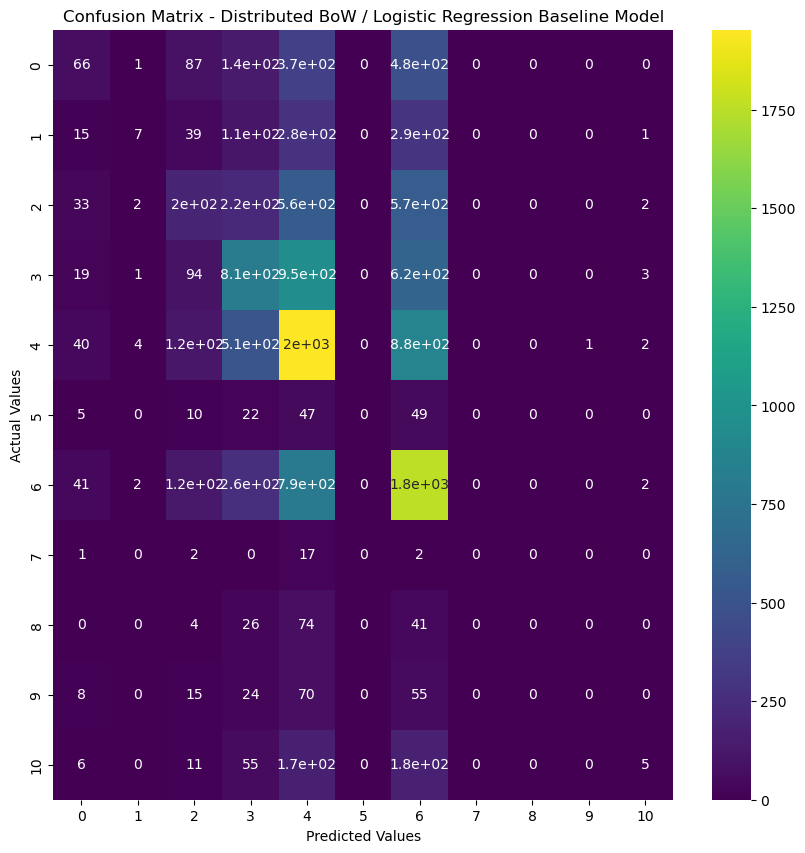

In [47]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lr_dbow, annot=True, cmap='viridis') #, ax=ax) #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Distributed BoW / Logistic Regression Baseline Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [48]:
# Output targets and regressors from user-defined vec_for_learning function - dm model
y_train_dm, X_train_dm = vec_for_learning(model_dm, train_tagged)
y_test_dm, X_test_dm = vec_for_learning(model_dm, test_tagged)

In [49]:
# Baseline label classifier with Logistic Regression and minimal params - dm model

logreg_dm = LogisticRegression(
    max_iter=10000,
    random_state=2022,
)

logreg_dm.fit(X_train_dm, y_train_dm)

y_pred_dm = logreg_dm.predict(X_test_dm)
print('Testing accuracy %s' % accuracy_score(y_test_dm, y_pred_dm))
print('Testing f1 score %s' % f1_score(y_test_dm, y_pred_dm, average='weighted'))
cm_lr_dm = confusion_matrix(y_test_dm, y_pred_dm) # can use to make heatmap
cr_lr_dm = pd.DataFrame(classification_report(y_test_dm, y_pred_dm, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_lr_dm

Testing accuracy 0.7082772040113755
Testing f1 score 0.696150607532337


,precision,recall,f1-score,support
0,0.735360,0.571804,0.643350,1142.000000
1,0.777465,0.375000,0.505958,736.000000
2,0.680184,0.560530,0.614587,1586.000000
3,0.669115,0.763673,0.713274,2505.000000
4,0.635813,0.837368,0.722803,3511.000000
5,0.562500,0.135338,0.218182,133.000000
6,0.848127,0.842158,0.845132,2984.000000
7,0.000000,0.000000,0.000000,22.000000
8,0.388889,0.048276,0.085890,145.000000
9,0.666667,0.290698,0.404858,172.000000


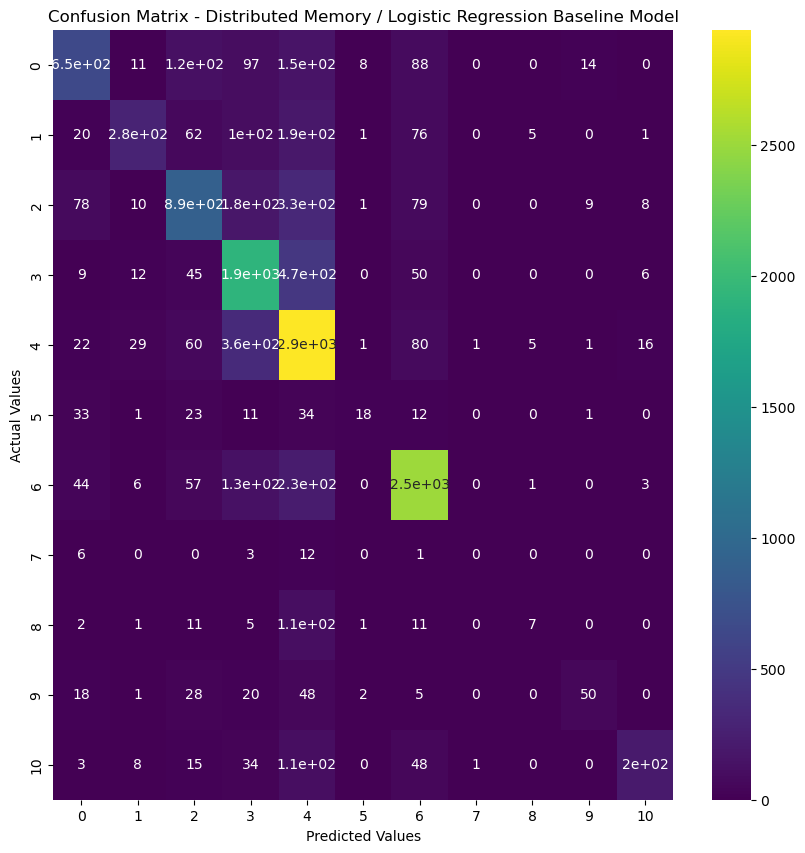

In [50]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lr_dm, annot=True, cmap='viridis') #, ax=ax) #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Distributed Memory / Logistic Regression Baseline Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Distributed Memory (dm) model performs much better on baseline than Distributed Bag-of-Words (dbow) model.  Will utilize dm model for additional modeling
- ### Baseline logistic regression with dm performs moderately well with accuracy and f1 score ~70%

In [51]:
# Rename dm targets and regressors to drop 'dm' suffix
y_train = y_train_dm
X_train = X_train_dm
y_test = y_test_dm 
X_test = X_test_dm

# Try hyperparameter optimization for the logistic regression model

In [52]:
# Optimize logistic regression classifier with optuna
def log_objective(trial):
    #penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet", "none"]) #use defaut l2 penalty
    tol = trial.suggest_float("tol", 0.0001, 0.0091, step=0.001, log=False)
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    #fit_intercept = trial.suggest_categorical("fit_intercept", ["True", "False"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "sag", "saga"]) #"liblinear", 
    #l1_ratio = trial.suggest_float("l1_ratio", 0.1, 1.0, step=0.1, log=False) ## only used by elasticnet
        
    ## Create Model
    log = LogisticRegression(tol=tol, C=C, class_weight=class_weight, solver=solver, 
                            max_iter=10000, multi_class = "multinomial", random_state = 2022) #fit_intercept=fit_intercept, l1_ratio=l1_ratio
    ## Fit Model
    log.fit(X_train, y_train)

    return accuracy_score(y_test, log.predict(X_test))

In [53]:
log_study = optuna.create_study(study_name="Logistic Regression Classifier", direction="maximize")
log_study.optimize(log_objective, n_trials=10)

[I 2022-12-18 11:08:05,660] A new study created in memory with name: Logistic Regression Classifier
[I 2022-12-18 11:08:41,222] Trial 0 finished with value: 0.6430175123484508 and parameters: {'tol': 0.0031, 'C': 0.4, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.6430175123484508.
[I 2022-12-18 11:11:07,219] Trial 1 finished with value: 0.6502769046549918 and parameters: {'tol': 0.0001, 'C': 0.6, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 1 with value: 0.6502769046549918.
[I 2022-12-18 11:11:12,074] Trial 2 finished with value: 0.6359077982337973 and parameters: {'tol': 0.0041, 'C': 0.2, 'class_weight': 'balanced', 'solver': 'lbfgs'}. Best is trial 1 with value: 0.6502769046549918.
[I 2022-12-18 11:12:11,034] Trial 3 finished with value: 0.6503517437509355 and parameters: {'tol': 0.0021, 'C': 0.8, 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 3 with value: 0.6503517437509355.
[I 2022-12-18 11:12:52,583] Trial 4 finished wi

In [54]:
print("Best Params: {}".format(log_study.best_params))
print("\nBest Accuracy: {}".format(log_study.best_value))

Best Params: {'tol': 0.0041, 'C': 0.9, 'class_weight': None, 'solver': 'sag'}

Best Accuracy: 0.7059571920371202


In [55]:
log_clf = LogisticRegression(**log_study.best_params, max_iter=10000, multi_class = "multinomial", random_state = 2022)
log_clf.fit(X_train, y_train)

y_pred_train = log_clf.predict(X_train)
y_pred_test = log_clf.predict(X_test)

log_train_acc = accuracy_score(y_train, y_pred_train)
log_test_acc = accuracy_score(y_test, y_pred_test)

log_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
log_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Logistic Regression Accuracy on Train Dataset: {}".format(log_train_acc))
print("\nLogistic Regression Accuracy on Test Dataset: {}".format(log_test_acc))
print("#####################")
print("\nLogistic Regression F1 Score on Train Dataset: {}".format(log_train_f1))
print("\nLogistic Regression F1 Score on Test Dataset: {}".format(log_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_log = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_log = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_log

Logistic Regression Accuracy on Train Dataset: 0.7585135843125514

Logistic Regression Accuracy on Test Dataset: 0.7059571920371202
#####################

Logistic Regression F1 Score on Train Dataset: 0.7506599615004835

Logistic Regression F1 Score on Test Dataset: 0.6929504063571713


,precision,recall,f1-score,support
0,0.736964,0.556918,0.634414,1142.000000
1,0.757746,0.365489,0.493126,736.000000
2,0.680769,0.558008,0.613306,1586.000000
3,0.671484,0.760479,0.713216,2505.000000
4,0.629204,0.841925,0.720185,3511.000000
5,0.531250,0.127820,0.206061,133.000000
6,0.848178,0.842493,0.845326,2984.000000
7,0.000000,0.000000,0.000000,22.000000
8,0.555556,0.034483,0.064935,145.000000
9,0.685714,0.279070,0.396694,172.000000


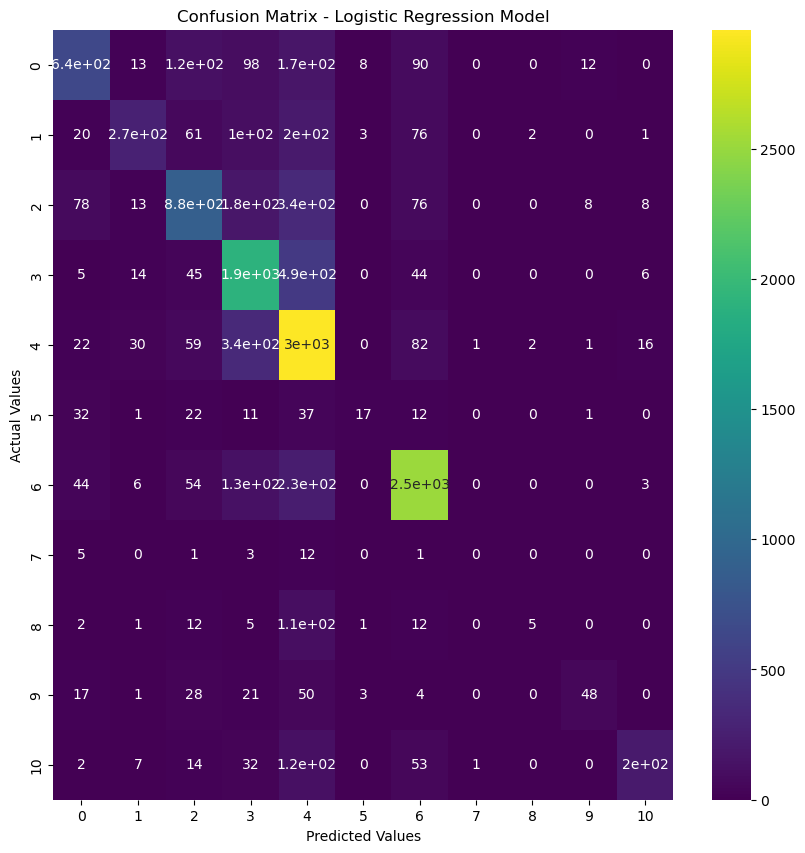

In [56]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_log, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Logistic Regression Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Hyperparameter optimization with Optuna did not exhibit much improvement for logistic regression classification accuracy and f1 score.
- ### Classification heatmap demonstrates good classification overall but high degree of misclassifications for class 4.
- ### Class 7 with least amount of support (22 samples) was only predicted twice and incorrectly.
- ### Slight evidence of overfitting with higher metrics on training data.

# Try other classification model types with hyperparameter optimization

## Passive Aggressive Classifier

In [59]:
# Passive Aggressive Classifier needs scaling preprocessing for input training data
scaler = MinMaxScaler() #scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Optimize passive aggressive classifier with optuna
def pac_objective(trial):
    C = trial.suggest_float("C", 0.1, 1.0, step=0.1, log=False)
    tol = trial.suggest_float("tol", 0.001, 0.01, step=0.001, log=False)
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
            
    ## Create Model
    pac = PassiveAggressiveClassifier(C=C, tol=tol, loss=loss, class_weight=class_weight, 
                                        max_iter=10000, random_state = 2022) 

    ## Fit Model
    pac.fit(X_scaled, y_train)

    return accuracy_score(y_test, pac.predict(X_test))

In [60]:
pac_study = optuna.create_study(study_name="Passive Aggressive Classifier", direction="maximize")
pac_study.optimize(pac_objective, n_trials=10)

[I 2022-12-18 12:50:33,704] A new study created in memory with name: Passive Aggressive Classifier
[I 2022-12-18 12:50:37,199] Trial 0 finished with value: 0.5699745547073791 and parameters: {'C': 1.0, 'tol': 0.01, 'loss': 'squared_hinge', 'class_weight': None}. Best is trial 0 with value: 0.5699745547073791.
[I 2022-12-18 12:50:41,413] Trial 1 finished with value: 0.002469690166142793 and parameters: {'C': 0.6, 'tol': 0.006, 'loss': 'squared_hinge', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5699745547073791.
[I 2022-12-18 12:50:45,461] Trial 2 finished with value: 0.6216135309085467 and parameters: {'C': 0.9, 'tol': 0.007, 'loss': 'squared_hinge', 'class_weight': None}. Best is trial 2 with value: 0.6216135309085467.
[I 2022-12-18 12:50:51,126] Trial 3 finished with value: 0.5393653644663973 and parameters: {'C': 0.7000000000000001, 'tol': 0.003, 'loss': 'hinge', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6216135309085467.
[I 2022-12-18 12:50:55,215] T

In [61]:
print("Best Params: {}".format(pac_study.best_params))
print("\nBest Accuracy: {}".format(pac_study.best_value))

Best Params: {'C': 0.9, 'tol': 0.007, 'loss': 'squared_hinge', 'class_weight': None}

Best Accuracy: 0.6216135309085467


In [62]:
pac_clf = PassiveAggressiveClassifier(**pac_study.best_params, max_iter=10000, random_state = 2022)
pac_clf.fit(X_scaled, y_train)

y_pred_train = pac_clf.predict(X_scaled)

# Scale X_test data the same as X_train data
X_scaled_test = scaler.fit_transform(X_test)
y_pred_test = pac_clf.predict(X_scaled_test)

pac_train_acc = accuracy_score(y_train, y_pred_train)
pac_test_acc = accuracy_score(y_test, y_pred_test)

pac_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
pac_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Passive Aggressive Classifier Accuracy on Train Dataset: {}".format(pac_train_acc))
print("\nPassive Aggressive Classifier Accuracy on Test Dataset: {}".format(pac_test_acc))
print("#####################")
print("\nPassive Aggressive Classifier F1 Score on Train Dataset: {}".format(pac_train_f1))
print("\nPassive Aggressive Classifier F1 Score on Test Dataset: {}".format(pac_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_pac = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_pac = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_pac

Passive Aggressive Classifier Accuracy on Train Dataset: 0.5781939974552803

Passive Aggressive Classifier Accuracy on Test Dataset: 0.5120490944469391
#####################

Passive Aggressive Classifier F1 Score on Train Dataset: 0.6053300873993797

Passive Aggressive Classifier F1 Score on Test Dataset: 0.5014964915674913


,precision,recall,f1-score,support
0,0.665359,0.445709,0.533823,1142.000000
1,0.812500,0.176630,0.290179,736.000000
2,0.240200,0.877049,0.377118,1586.000000
3,0.952744,0.249501,0.395444,2505.000000
4,0.831615,0.413557,0.552406,3511.000000
5,0.666667,0.015038,0.029412,133.000000
6,0.639462,0.892761,0.745175,2984.000000
7,1.000000,0.000000,0.000000,22.000000
8,1.000000,0.000000,0.000000,145.000000
9,0.750000,0.069767,0.127660,172.000000


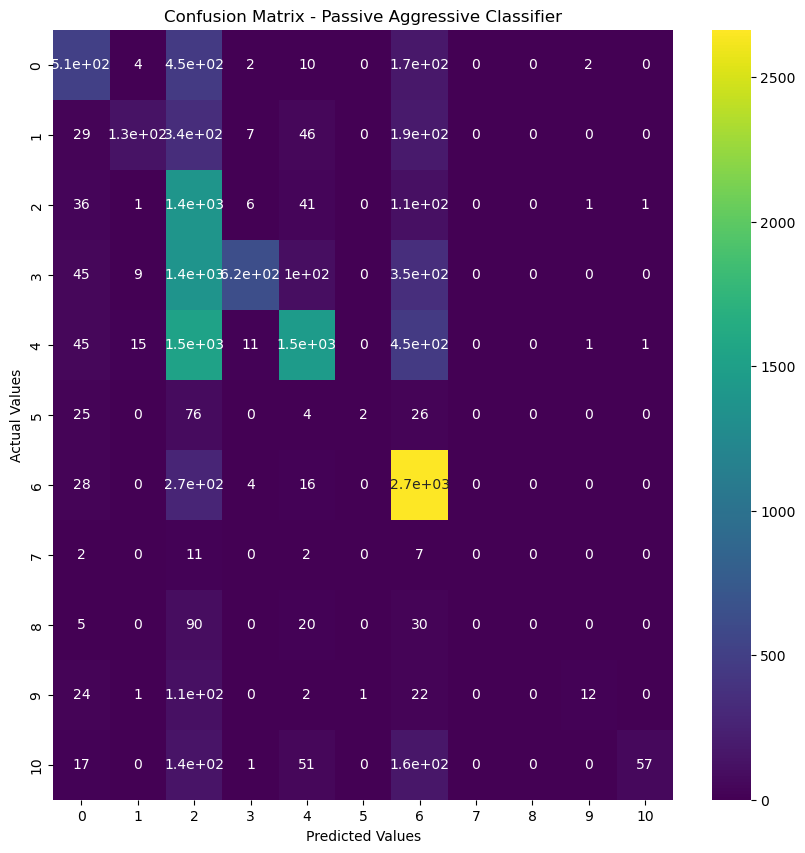

In [63]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_pac, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Passive Aggressive Classifier performed worse than Logistic Regression Classifier in terms of accuracy and f1 score.
- ### Classification heatmap demonstrates fair classification overall but high degree of misclassifications in classes 2 and 6.
- ### Class 7 with least amount of support (22 samples) was not predicted once.
- ### Slight evidence of overfitting with higher metrics on training data.

## Random Forest Classifier

In [64]:
# Optimize Random Forest Classifier with optuna
def rfc_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 550, step=100, log=False)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    max_depth = trial.suggest_int("max_depth", 2, 10, step=2, log=False)
    min_samples_split = trial.suggest_int("min_samples_split", 20, 100, step=20, log=False)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 10, 50, step=10, log=False)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", ["balanced", "balanced_subsample"])
            
    ## Create Model
    rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, 
                                    min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap=bootstrap, class_weight=class_weight, 
                                    random_state = 2022) 

    ## Fit Model
    rfc.fit(X_train, y_train)

    return accuracy_score(y_test, rfc.predict(X_test))

In [65]:
rfc_study = optuna.create_study(study_name="Random Forest Classifier", direction="maximize")
rfc_study.optimize(rfc_objective, n_trials=10)

[I 2022-12-18 12:52:22,259] A new study created in memory with name: Random Forest Classifier
[I 2022-12-18 13:37:33,041] Trial 0 finished with value: 0.21366561891932345 and parameters: {'n_estimators': 450, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 100, 'min_samples_leaf': 50, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.21366561891932345.
[I 2022-12-18 13:41:37,929] Trial 1 finished with value: 0.32525071097141145 and parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 40, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.32525071097141145.
[I 2022-12-18 13:44:44,453] Trial 2 finished with value: 0.3182158359527017 and parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 80, 'min_samples_leaf': 20, 'max_features': 'log2', 'bootstrap': False, 'class_wei

In [66]:
print("Best Params: {}".format(rfc_study.best_params))
print("\nBest Accuracy: {}".format(rfc_study.best_value))

Best Params: {'n_estimators': 550, 'criterion': 'log_loss', 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}

Best Accuracy: 0.4579404280796288


In [67]:
rfc_clf = RandomForestClassifier(**rfc_study.best_params, random_state = 2022)
rfc_clf.fit(X_train, y_train)

y_pred_train = rfc_clf.predict(X_train)
y_pred_test = rfc_clf.predict(X_test)

rfc_train_acc = accuracy_score(y_train, y_pred_train)
rfc_test_acc = accuracy_score(y_test, y_pred_test)

rfc_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
rfc_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("Random Forest Classifier Accuracy on Train Dataset: {}".format(rfc_train_acc))
print("\nRandom Forest Classifier Accuracy on Test Dataset: {}".format(rfc_test_acc))
print("#####################")
print("\nRandom Forest Classifier F1 Score on Train Dataset: {}".format(rfc_train_f1))
print("\nRandom Forest Classifier F1 Score on Test Dataset: {}".format(rfc_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_rfc = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_rfc = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_rfc

Random Forest Classifier Accuracy on Train Dataset: 0.6199573385225656

Random Forest Classifier Accuracy on Test Dataset: 0.4579404280796288
#####################

Random Forest Classifier F1 Score on Train Dataset: 0.61857135685697

Random Forest Classifier F1 Score on Test Dataset: 0.45473242579885037


,precision,recall,f1-score,support
0,0.500724,0.302977,0.377523,1142.00000
1,0.433333,0.211957,0.284672,736.00000
2,0.455135,0.265448,0.335325,1586.00000
3,0.441781,0.772455,0.562092,2505.00000
4,0.625203,0.329251,0.431343,3511.00000
5,0.250000,0.255639,0.252788,133.00000
6,0.598872,0.569370,0.583748,2984.00000
7,0.000000,0.000000,0.000000,22.00000
8,0.072323,0.358621,0.120370,145.00000
9,0.169557,0.511628,0.254703,172.00000


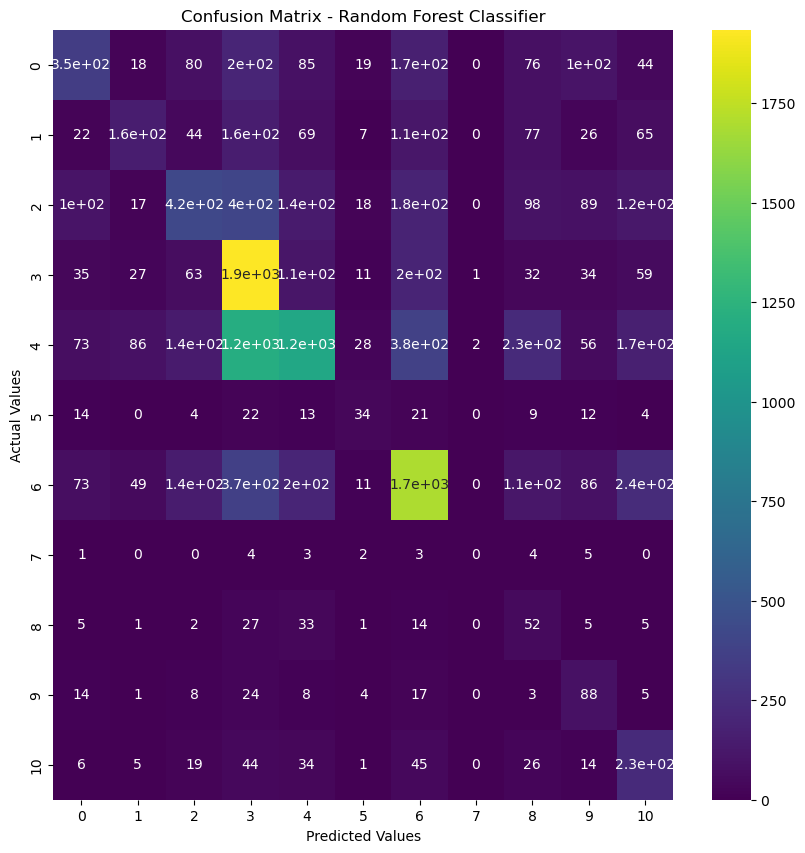

In [68]:
# Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_rfc, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - Random Forest Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### Random Forest Classifier performed worse than the Logistic Regression Classifier and about the same as the Passive Aggressive Classifier.
- ### Classification heatmap demonstrates fairly poor classification overall with high degree of misclassifications in classes 3, 4, 6, 8, and 10.
- ### Class 7 with least amount of support (22 samples) was only predicted three times and those predictions were incorrect.
- ### Evidence of overfitting with higher metrics on training data.

## XGBoost Classifier

In [69]:
# XGBoost Classifier needs y_train label encoded
#le = LabelEncoder() #scaler = StandardScaler()
#y_train_le = le.fit_transform(y_train)

# Optimize XGBoost Classifier Classifier with optuna
def xgb_objective(trial):
    booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    eta = trial.suggest_float("eta", 0.1, 1.0, step=0.1, log=False)
    gamma = trial.suggest_int("gamma", 0, 100, step=10, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 42, step=4, log=False)
    min_child_weight = trial.suggest_int("min_child_weight", 0, 50, step=10, log=False)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1, log=False)
    #sampling_method = trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"]) #gradient_based only for tree_method: gpu_hist
            
    ## Create Model
    xgb = XGBClassifier(booster=booster, eta=eta, gamma=gamma, max_depth=max_depth, min_child_weight=min_child_weight, 
                            subsample=subsample, eval_metric="mlogloss", use_label_encoder=False, random_state = 2022) # sampling_method=sampling_method,

    ## Fit Model
    xgb.fit(X_train, y_train)

    return accuracy_score(y_test, xgb.predict(X_test))

In [70]:
xgb_study = optuna.create_study(study_name="XGBoost Classifier", direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10)

[I 2022-12-18 18:29:39,042] A new study created in memory with name: XGBoost Classifier
C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2022-12-18 18:47:23,234] Trial 0 finished with value: 0.5143691064211944 and parameters: {'booster': 'dart', 'eta': 0.1, 'gamma': 80, 'max_depth': 34, 'min_child_weight': 10, 'subsample': 1.0}. Best is trial 0 with value: 0.5143691064211944.
C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2022-12-18 18:53:28,284] Trial 1 finished with value: 0.5200568777129172 and parameters: {'booster': 'gbtree', 'eta': 0.30000000000000004, 'gamma': 70, 'max_depth': 34, 'min_child_weight': 50, 'subsample': 0.8}. Best is trial 1 with value: 0.52005687

[19:04:57] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-12-18 19:05:16,938] Trial 3 finished with value: 0.7091752731627002 and parameters: {'booster': 'gblinear', 'eta': 0.5, 'gamma': 50, 'max_depth': 6, 'min_child_weight': 30, 'subsample': 0.7}. Best is trial 3 with value: 0.7091752731627002.
C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2022-12-18 19:33:48,271] Trial 4 finished with value: 0.6157760814249363 and parameters: {'booster': 'dart', 'eta': 0.7000000000000001, 'gamma': 0, 'max_depth': 26, 'min_child_weight': 0, 'subsample': 1.0}. Best is trial 3 with value: 0.7091752731627002.
C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[19:33:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-12-18 19:34:08,128] Trial 5 finished with value: 0.710297859601856 and parameters: {'booster': 'gblinear', 'eta': 0.5, 'gamma': 70, 'max_depth': 14, 'min_child_weight': 30, 'subsample': 1.0}. Best is trial 5 with value: 0.710297859601856.
C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2022-12-18 19:40:45,109] Trial 6 finished with value: 0.4906451130070349 and parameters: {'booster': 'gbtree', 'eta': 0.5, 'gamma': 100, 'max_depth': 22, 'min_child_weight': 50, 'subsample': 0.9}. Best is trial 5 with value: 0.710297859601856.
C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2022-12-18 19:50:59,496] Trial 7 finished with value: 0.505912288579554 and parameters: {

[20:05:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



[I 2022-12-18 20:05:40,649] Trial 9 finished with value: 0.7093249513545876 and parameters: {'booster': 'gblinear', 'eta': 0.5, 'gamma': 40, 'max_depth': 38, 'min_child_weight': 50, 'subsample': 0.6}. Best is trial 5 with value: 0.710297859601856.


In [71]:
print("Best Params: {}".format(xgb_study.best_params))
print("\nBest Accuracy: {}".format(xgb_study.best_value))

Best Params: {'booster': 'gblinear', 'eta': 0.5, 'gamma': 70, 'max_depth': 14, 'min_child_weight': 30, 'subsample': 1.0}

Best Accuracy: 0.710297859601856


In [72]:
xgb_clf = XGBClassifier(**xgb_study.best_params, use_label_encoder=False, eval_metric="mlogloss", random_state = 2022)
xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

xgb_train_acc = accuracy_score(y_train, y_pred_train)
xgb_test_acc = accuracy_score(y_test, y_pred_test)

xgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
xgb_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("XGBoost Classifier Accuracy on Train Dataset: {}".format(xgb_train_acc))
print("\nXGBoost Classifier Accuracy on Test Dataset: {}".format(xgb_test_acc))
print("#####################")
print("\nXGBoost Classifier F1 Score on Train Dataset: {}".format(xgb_train_f1))
print("\nXGBoost Classifier F1 Score on Test Dataset: {}".format(xgb_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_xgb = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_xgb = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_xgb

C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[20:05:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

XGBoost Classifier Accuracy on Train Dataset: 0.7771499139285981

XGBoost Classifier Accuracy on Test Dataset: 0.7091004340667565
#####################

XGBoost Classifier F1 Score on Train Dataset: 0.7745985251865971

XGBoost Classifier F1 Score on Test Dataset: 0.7007335363815196


,precision,recall,f1-score,support
0,0.718818,0.575306,0.639105,1142.0000
1,0.675000,0.403533,0.505102,736.0000
2,0.677321,0.561160,0.613793,1586.0000
3,0.677419,0.762874,0.717612,2505.0000
4,0.652075,0.818855,0.726010,3511.0000
5,0.530612,0.195489,0.285714,133.0000
6,0.849558,0.836461,0.842958,2984.0000
7,0.000000,0.000000,0.000000,22.0000
8,0.363636,0.137931,0.200000,145.0000
9,0.612403,0.459302,0.524917,172.0000


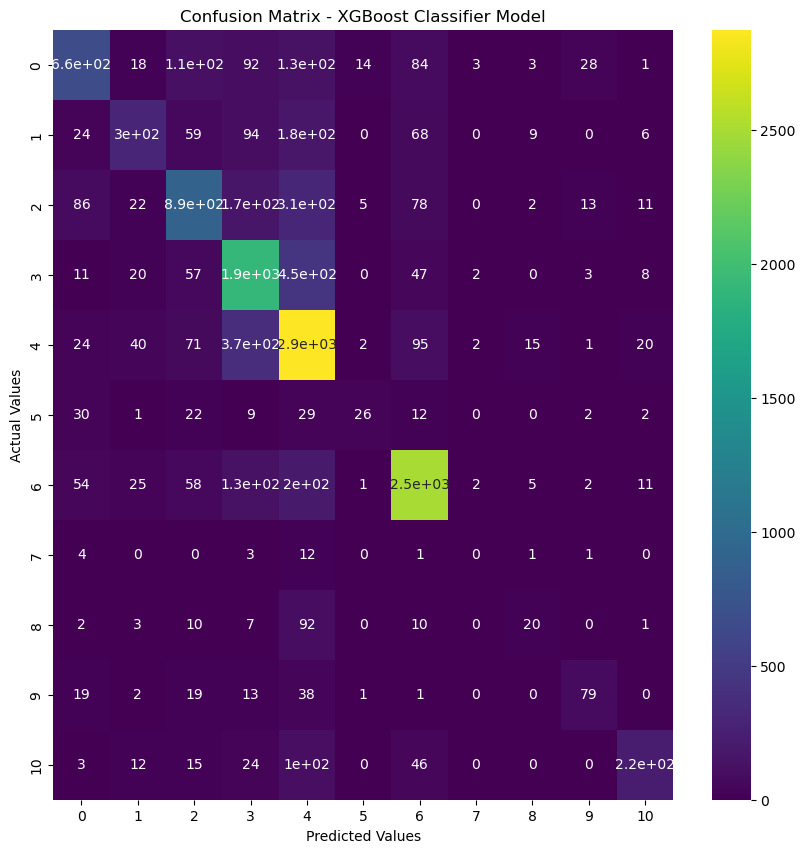

In [73]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_xgb, annot=True, cmap='viridis') #, ax=ax) #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - XGBoost Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### XGBoost Classifier performed similar to the Logistic Regression Classifier and, therefore, better than the Passive Aggressive or Random Forest Classifiers.
- ### Classification heatmap demonstrates good classification overall but high degree of misclassifications between classes 3 and 4, and class 4 classified as 2.
- ### Class 7 with least amount of support (22 samples) was predicted 9 times and each prediction was incorrect.
- ### Slight evidence of overfitting with slightly higher metrics on training data.

## LightGBM Classifier

In [74]:
# Optimize LightGBM Classifier Classifier with optuna
def lgb_objective(trial):
    #boosting_type = trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss", "rf"])
    num_leaves = trial.suggest_int("num_leaves", 4, 20, step=4, log=False)
    max_depth = trial.suggest_int("max_depth", 2, 8, step=2, log=False)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.010, step=0.001, log=False)
    n_estimators = trial.suggest_int("n_estimators", 350, 500, step=25, log=False)
    min_child_weight = trial.suggest_float("min_child_weight", 0.01, 0.10, step=0.01, log=False)
    min_child_samples = trial.suggest_int("min_child_samples", 100, 200, step=25, log=False)
    subsample = trial.suggest_float("subsample", 0.2, 1.0, step=0.2, log=False)
            
    ## Create Model
    lgb = LGBMClassifier(boosting_type="gbdt", num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, 
                            n_estimators=n_estimators, min_child_weight=min_child_weight, min_child_samples=min_child_samples, 
                            subsample=subsample, objective="multiclass", random_state = 2022) 

    ## Fit Model
    lgb.fit(X_train, y_train)

    return accuracy_score(y_test, lgb.predict(X_test))

In [75]:
lgb_study = optuna.create_study(study_name="LightGBM Classifier", direction="maximize")
lgb_study.optimize(lgb_objective, n_trials=10)

[I 2022-12-18 20:06:02,530] A new study created in memory with name: LightGBM Classifier
[I 2022-12-18 20:06:39,181] Trial 0 finished with value: 0.558748690315821 and parameters: {'num_leaves': 12, 'max_depth': 8, 'learning_rate': 0.009000000000000001, 'n_estimators': 375, 'min_child_weight': 0.06999999999999999, 'min_child_samples': 100, 'subsample': 0.4}. Best is trial 0 with value: 0.558748690315821.
[I 2022-12-18 20:07:23,702] Trial 1 finished with value: 0.5220775333033977 and parameters: {'num_leaves': 20, 'max_depth': 6, 'learning_rate': 0.004, 'n_estimators': 375, 'min_child_weight': 0.01, 'min_child_samples': 200, 'subsample': 0.8}. Best is trial 0 with value: 0.558748690315821.
[I 2022-12-18 20:07:56,112] Trial 2 finished with value: 0.5618919323454573 and parameters: {'num_leaves': 12, 'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 350, 'min_child_weight': 0.08, 'min_child_samples': 175, 'subsample': 0.8}. Best is trial 2 with value: 0.5618919323454573.
[I 2022-12-1

In [76]:
print("Best Params: {}".format(lgb_study.best_params))
print("\nBest Accuracy: {}".format(lgb_study.best_value))

Best Params: {'num_leaves': 16, 'max_depth': 6, 'learning_rate': 0.01, 'n_estimators': 425, 'min_child_weight': 0.06999999999999999, 'min_child_samples': 200, 'subsample': 0.2}

Best Accuracy: 0.5875617422541536


In [77]:
lgb_clf = LGBMClassifier(**lgb_study.best_params, boosting_type="gbdt", objective="multiclass", random_state = 2022)
lgb_clf.fit(X_train, y_train)

y_pred_train = lgb_clf.predict(X_train)
y_pred_test = lgb_clf.predict(X_test)

lgb_train_acc = accuracy_score(y_train, y_pred_train)
lgb_test_acc = accuracy_score(y_test, y_pred_test)

lgb_train_f1 = f1_score(y_train, y_pred_train, average='weighted')
lgb_test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print("LightGBM Classifier Accuracy on Train Dataset: {}".format(lgb_train_acc))
print("\nLightGBM Classifier Accuracy on Test Dataset: {}".format(lgb_test_acc))
print("#####################")
print("\nLightGBM Classifier F1 Score on Train Dataset: {}".format(lgb_train_f1))
print("\nLightGBM Classifier F1 Score on Test Dataset: {}".format(lgb_test_f1))

# Create Test Confusion Matrix and Classification Report
cm_lgb = confusion_matrix(y_test, y_pred_test) # can use to make heatmap
cr_lgb = pd.DataFrame(classification_report(y_test, y_pred_test, zero_division=1, output_dict=True)).T #, average= 'weighted')
cr_lgb

LightGBM Classifier Accuracy on Train Dataset: 0.6753424144899334

LightGBM Classifier Accuracy on Test Dataset: 0.5875617422541536
#####################

LightGBM Classifier F1 Score on Train Dataset: 0.6620863450187259

LightGBM Classifier F1 Score on Test Dataset: 0.5586953933987496


,precision,recall,f1-score,support
0,0.653846,0.297723,0.409146,1142.000000
1,0.753731,0.137228,0.232184,736.000000
2,0.554622,0.374527,0.447121,1586.000000
3,0.594080,0.697006,0.641440,2505.000000
4,0.529963,0.773284,0.628909,3511.000000
5,0.583333,0.052632,0.096552,133.000000
6,0.654589,0.738606,0.694064,2984.000000
7,1.000000,0.000000,0.000000,22.000000
8,0.375000,0.020690,0.039216,145.000000
9,0.600000,0.156977,0.248848,172.000000


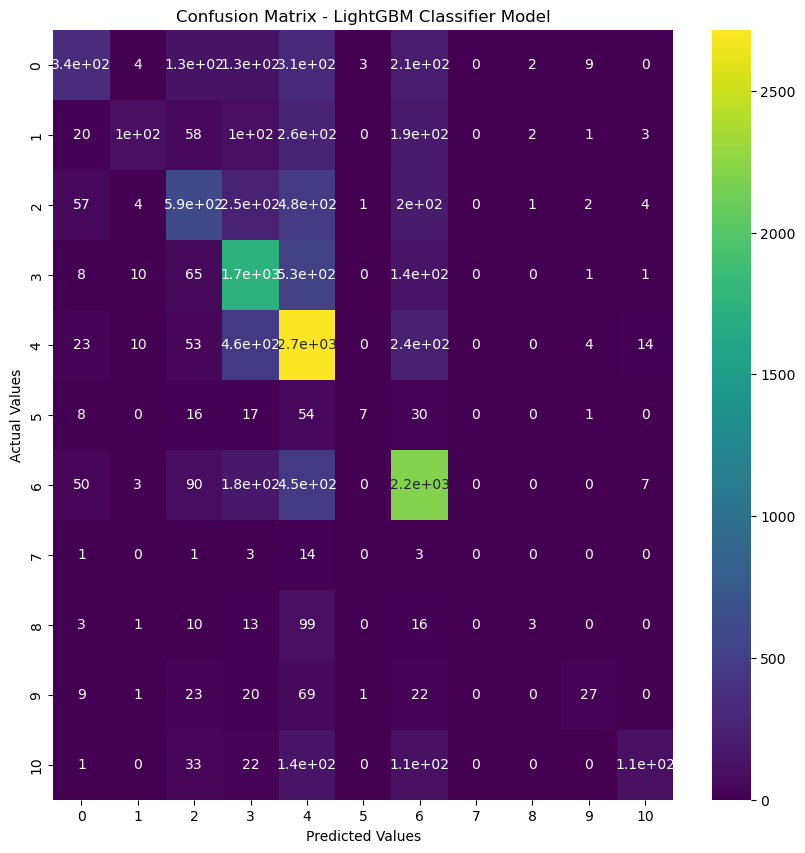

In [78]:
#Plotting the confusion matrix as heatmap
plt.figure(figsize=(10,10))
sns.heatmap(cm_lgb, annot=True, cmap='viridis') #, cmap='crest')#, linewidth=.1)#, annot=True)
plt.title('Confusion Matrix - LightGBM Classifier Model')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

- ### LightGBM Classifier performed about the same as the Passive Aggressive Classifier, worse than the Logistic Regression and XGBoost Classifiers, and better than the Random Forest Classifier in terms of accuracy and f1 score.
- ### Classification heatmap demonstrates fairly poor classification overall with a high degree of misclassifications for classes 3, 4, and 6.
- ### Class 7 with least amount of support (22 samples) was not predicted once.
- ### Some evidence of overfitting with slightly higher metrics on training data.

## Save models

In [79]:
# save models
pickle.dump(log_clf, open('./bin/Doc2Vec/log_clf.pkl', 'wb'))
pickle.dump(pac_clf, open('./bin/Doc2Vec/pac_clf.pkl', 'wb'))
pickle.dump(rfc_clf, open('./bin/Doc2Vec/rfc_clf.pkl', 'wb'))
pickle.dump(xgb_clf, open('./bin/Doc2Vec/xgb_clf.pkl', 'wb'))
pickle.dump(lgb_clf, open('./bin/Doc2Vec/lgb_clf.pkl', 'wb'))

## Ensemble best models together to balance bias-variance tradeoff / mitigate any overfitting.

In [80]:
# load 2 best saved models
log_clf = pickle.load(open('./bin/Doc2Vec/log_clf.pkl', 'rb'))
xgb_clf = pickle.load(open('./bin/Doc2Vec/xgb_clf.pkl', 'rb'))

In [81]:
ensemble_clf = VotingClassifier(estimators=[('log', log_clf), ('xgb', xgb_clf)], 
                                    voting='soft') # can use 'soft' argmax voting since log and xgb both have predict_proba

In [82]:
ensemble_clf = ensemble_clf.fit(X_train, y_train)

C:\Users\schellr2\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[20:44:22] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } are not used.



In [83]:
y_pred_train_ensemble = ensemble_clf.predict(X_train)
y_pred_test_ensemble = ensemble_clf.predict(X_test)

In [84]:
results_ensemble_train_acc = accuracy_score(y_train, y_pred_train_ensemble)
results_ensemble_test_acc = accuracy_score(y_test, y_pred_test_ensemble)

results_ensemble_train_f1 = f1_score(y_train, y_pred_train_ensemble, average='weighted')
results_ensemble_test_f1 = f1_score(y_test, y_pred_test_ensemble, average='weighted')

print("Ensemble Accuracy on Train Dataset: {}".format(results_ensemble_train_acc))
print("\nEnsemble Accuracy on Test Dataset: {}".format(results_ensemble_test_acc))
print("#####################")
print("\nEnsemble F1 Score on Train Dataset: {}".format(results_ensemble_train_f1))
print("\nEnsemble F1 Score on Test Dataset: {}".format(results_ensemble_test_f1))

Ensemble Accuracy on Train Dataset: 0.7730147444053589

Ensemble Accuracy on Test Dataset: 0.7119443197126178
#####################

Ensemble F1 Score on Train Dataset: 0.7693148809351417

Ensemble F1 Score on Test Dataset: 0.7019527626120894


- ### Only slight overfitting to training data and Accuracy / f1 scores are slightly better when ensembling Logistic Regression and XGBoost Classifiers using 'soft' argmax voting (predict_proba). 

## Final Thoughts:
- ### Results for Gensim's Doc2Vec embedded vectors are not as good as previous tfidf modeling.
- ### Try pretrained Transformers from huggingface next.